# Dataset: Tic Tac Toe
# Focus task: Classifier and Regressor

## Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix, precision_score, zero_one_loss, hinge_loss, recall_score, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Loading the raw data

In [2]:
# Reading raw data from txt file and typecasting the data columns to have type catecorical
tictac_final = np.loadtxt("Datasets/Tic-Tac-Toe/tictac_final.txt", dtype=object)
tictac_single = np.loadtxt("Datasets/Tic-Tac-Toe/tictac_single.txt", dtype=object)
tictac_multi = np.loadtxt("Datasets/Tic-Tac-Toe/tictac_multi.txt")

#columnn names based on states on the tictactoe board and winner(outcome)
tictac_final_data = pd.DataFrame(tictac_final, columns = ["x0", "x1","x2", "x3", "x4","x5", "x6", "x7", "x8", "y"])
tictac_single_data = pd.DataFrame(tictac_single, columns = ["x0", "x1","x2", "x3", "x4","x5", "x6", "x7", "x8", "y"])
tictac_multi_data = pd.DataFrame(tictac_multi, columns = ["x0", "x1","x2", "x3", "x4","x5", "x6", "x7", "x8", "y0", "y1","y2", "y3", "y4","y5", "y6", "y7", "y8"])

# #exploring the raw dataset
# print(tictac_final_data.head())
# print(tictac_single_data.head())
# print(tictac_multi_data.head())

#### We have typecasted the variables after exploring the dataset, since we discovered that the features x0,...,x8 were only taking 3 values(-1,0,1) and the target variable was taking : a) 2 values (-1, 1) for Tic Tac Toe Final boards classification dataset; b) 9 values (0...8) for Tic Tac Toe Intermediate boards optimal play (single label); c) 2 values (0, 1) for Tic Tac Toe Intermediate boards optimal play (multi label)

In [3]:
#basic information
tictac_final_data.info()
tictac_single_data.info() 
tictac_multi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x0      958 non-null    object
 1   x1      958 non-null    object
 2   x2      958 non-null    object
 3   x3      958 non-null    object
 4   x4      958 non-null    object
 5   x5      958 non-null    object
 6   x6      958 non-null    object
 7   x7      958 non-null    object
 8   x8      958 non-null    object
 9   y       958 non-null    object
dtypes: object(10)
memory usage: 75.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6551 entries, 0 to 6550
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x0      6551 non-null   object
 1   x1      6551 non-null   object
 2   x2      6551 non-null   object
 3   x3      6551 non-null   object
 4   x4      6551 non-null   object
 5   x5      6551 non-null   object
 6   x6      6551 non-null

In [4]:
#checking the features for occurance of each categorical value
print(tictac_final_data.apply(pd.Series.value_counts))
print(tictac_single_data.iloc[:,0:9].apply(pd.Series.value_counts))
print(tictac_multi_data.apply(pd.Series.value_counts))

     x0   x1   x2   x3   x4   x5   x6   x7   x8      y
+1  418  378  418  378  458  378  418  378  418  626.0
-1  335  330  335  330  340  330  335  330  335  332.0
0   205  250  205  250  160  250  205  250  205    NaN
      x0    x1    x2    x3    x4    x5    x6    x7    x8
0   2646  2537  2638  2544  2743  2537  2648  2539  2642
1   2115  2323  2136  2261  2038  2304  2180  2277  2173
-1  1790  1691  1777  1746  1770  1710  1723  1735  1736
        x0    x1    x2    x3    x4    x5    x6    x7    x8      y0      y1  \
-1.0  1790  1691  1777  1746  1770  1710  1723  1735  1736     NaN     NaN   
 0.0  2646  2537  2638  2544  2743  2537  2648  2539  2642  4987.0  5390.0   
 1.0  2115  2323  2136  2261  2038  2304  2180  2277  2173  1564.0  1161.0   

          y2      y3      y4      y5      y6      y7      y8  
-1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
 0.0  5005.0  5372.0  4629.0  5371.0  4974.0  5382.0  5000.0  
 1.0  1546.0  1179.0  1922.0  1180.0  1577.0  1169

In [5]:
#checking the target variable for occurance of each categorical value
print(tictac_final_data["y"].value_counts())
print(tictac_single_data["y"].value_counts())

+1    626
-1    332
Name: y, dtype: int64
0    1564
4    1046
2     973
1     845
6     544
3     513
8     459
5     353
7     254
Name: y, dtype: int64


In [6]:
#checking number of records
print(f'final: {tictac_final_data.shape}')
print(f'single: {tictac_single_data.shape}')
print(f'multi: {tictac_multi_data.shape}')

final: (958, 10)
single: (6551, 10)
multi: (6551, 18)


## Random sampling and cross validation setup

In [7]:
#shuffling the records of the dataframe and split for train and test data
def split_data(data, regressor = False):
    shuffled_data = data.sample(frac=1, random_state=500).reset_index().drop(['index'],axis = 1)
    if regressor:
        X_train, X_test, y_train, y_test = train_test_split(shuffled_data.iloc[:,0:9], shuffled_data.iloc[:,9:], test_size=0.33, random_state=10)
    else:
        X_train, X_test, y_train, y_test = train_test_split(shuffled_data.iloc[:,0:9], shuffled_data.iloc[:,9], test_size=0.33, random_state=42)
    print(f'Sizes of train and test datasets:{X_train.shape,y_train.shape,X_test.shape,y_test.shape}')
    return X_train, X_test, y_train, y_test

In [8]:
# final_shuffled_data = split_data(tictac_final_data, False)
# single_shuffled_data = split_data(tictac_single_data, False)
# multi_shuffled_data = split_data(tictac_multi_data, True)

In [9]:
def kfold_split(X_train, y_train):#set K value for cross validation 
    cv = KFold(n_splits=10, random_state=70, shuffle=True)

    #making the splits
    kfold = cv.split(X_train, y_train)
    return kfold, cv
scores = []

## Classifier Model

In [10]:
def preprocess(data, fraction, regression = False):
    if fraction:
        fraction_size = int(np.round(data.shape[0] / 10))
        data = data.sample(fraction_size)
        print(data.shape)
    X_train, X_test, y_train, y_test = split_data(data, regression)
    return X_train, X_test, y_train, y_test

In [11]:
def model(model, data, fraction, mlp = False, svm = False):
    X_train, X_test, y_train, y_test = preprocess(data, fraction, False)
    kfold, cv = kfold_split(X_train, y_train)
    scores = []
    zeroOneLoss = []
    lossFinal = []
    for k, (train, test) in enumerate(kfold):
        train_model = model.fit(X_train.iloc[train, :], y_train.iloc[train])
        score = model.score(X_train.iloc[test, :], y_train.iloc[test])
        y_pred_test = model.predict(X_train.iloc[test, :])
        zero_loss = zero_one_loss(y_pred_test, y_train.iloc[test])
       
        if mlp:
            loss = train_model.loss_
            lossFinal.append(loss)
        if svm: 
            zero_loss = zero_one_loss(y_pred_test, y_train.iloc[test])
            zeroOneLoss.append(zero_loss)
        scores.append(score)
        
        print(f'Fold: {k+1}      Accuracy: {score}')  
    scores = cross_val_score(train_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    if mlp:
        print('Train accuracy (Loss): %.3f (%.3f)' % (np.mean(scores), sum(lossFinal) / float(len(lossFinal))))
        y_pred = accuracyScore(train_model, X_test, y_test, False, False)
    elif svm:
        print('Train accuracy (Loss): %.3f (%.3f)' % (np.mean(scores), sum(zeroOneLoss) / float(len(zeroOneLoss))))
        y_pred = accuracyScore(train_model, X_test, y_test, False, True)
    else: 
        print('Train accuracy: %.3f' % (np.mean(scores)))
        y_pred = accuracyScore(train_model, X_test, y_test, False)
    confusionMatrix(y_test, y_pred)
    return train_model

In [12]:
def accuracyScore(model, X_test, y_test, regressor, svm = False):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1Score = f1_score(y_test, y_pred, average='macro') 
    if svm:
        zero_one = zero_one_loss(y_test, y_pred)
        print('Test Accuracy (Loss): %.3f (%.3f)' % (accuracy,zero_one) ) 
    else:
        print('Test Accuracy: %.3f' % (accuracy) )
    print('Precision: %.3f' % (precision))
    print('Recall: %.3f' % (recall))
    print('F1_score: %.3f' % (f1Score))
    return y_pred

In [13]:
def confusionMatrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred, normalize = 'all')
    normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(normalized_matrix, annot=True, fmt='.4f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=True)

### Model A: Linear SVM

#### Linear SVM for Tic Tac Toe Final boards classification dataset

Linear SVM for final boards classification dataset
Sizes of train and test datasets:((641, 9), (641,), (317, 9), (317,))
Fold: 1      Accuracy: 0.9846153846153847
Fold: 2      Accuracy: 0.9375
Fold: 3      Accuracy: 1.0
Fold: 4      Accuracy: 1.0
Fold: 5      Accuracy: 0.96875
Fold: 6      Accuracy: 1.0
Fold: 7      Accuracy: 0.984375
Fold: 8      Accuracy: 1.0
Fold: 9      Accuracy: 0.96875
Fold: 10      Accuracy: 1.0
Train accuracy (Loss): 0.984 (0.016)
Test Accuracy (Loss): 0.981 (0.019)
Precision: 0.985
Recall: 0.975
F1_score: 0.980


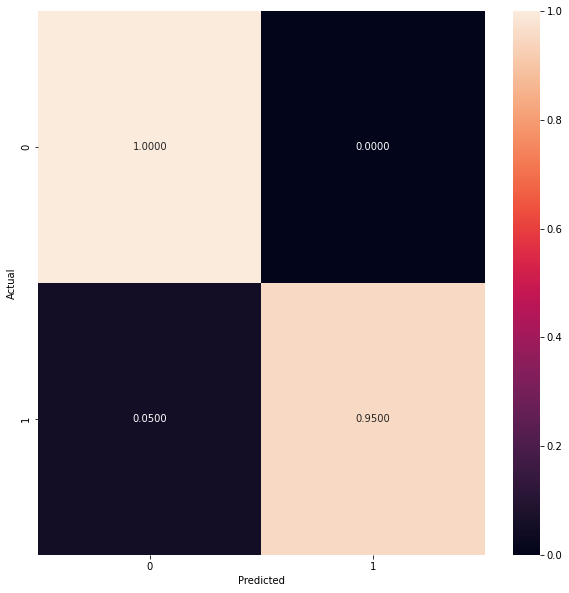

SVC(decision_function_shape='ovo', gamma=10, kernel='linear')

In [14]:
def svmFinal(tictac_final_data, fraction):
#     X_train, X_test, y_train, y_test = preprocess(tictac_final_data, fraction, False)
#     kfold, cv = kfold_split(X_train, y_train)
#     param_grid = {"kernel": ['linear', 'rbf', 'sigmoid'], "C": [1.0, 0.5, 0.1],
#                  "gamma":[10, 0.01], "decision_function_shape":['ovo', 'ovr']}
#     svm_gscv = GridSearchCV(SVC(), param_grid, cv=cv, n_jobs=-1)
#     svm_gscv.fit(X_train, y_train)

#     best_hyperparams = svm_gscv.best_params_
#     optimal_kernel = best_hyperparams["kernel"]
#     optimal_c = best_hyperparams["C"]
#     optimal_gamma = best_hyperparams["gamma"]
#     optimal_decision_function_shape = best_hyperparams["decision_function_shape"]

#     print(optimal_kernel)
#     print(optimal_c)
#     print(optimal_gamma)
#     print(optimal_decision_function_shape)
    
    #creating the model
#     svm_final = SVC(kernel=optimal_kernel, C = optimal_c, gamma = optimal_gamma, 
#                     decision_function_shape = optimal_decision_function_shape)
    svm_final = SVC(kernel='linear', C = 1.0, gamma = 10, 
                    decision_function_shape = 'ovo')
    return svm_final

svm_final = svmFinal(tictac_final_data, fraction = False)
print('Linear SVM for final boards classification dataset')
model(svm_final, tictac_final_data, fraction = False, svm = True)


Linear SVM for final boards classification dataset with 1/10th data
(96, 10)
Sizes of train and test datasets:((64, 9), (64,), (32, 9), (32,))
Fold: 1      Accuracy: 0.8571428571428571
Fold: 2      Accuracy: 0.5714285714285714
Fold: 3      Accuracy: 1.0
Fold: 4      Accuracy: 1.0
Fold: 5      Accuracy: 1.0
Fold: 6      Accuracy: 1.0
Fold: 7      Accuracy: 0.8333333333333334
Fold: 8      Accuracy: 0.6666666666666666
Fold: 9      Accuracy: 0.8333333333333334
Fold: 10      Accuracy: 0.5
Train accuracy (Loss): 0.826 (0.174)
Test Accuracy (Loss): 0.844 (0.156)
Precision: 0.904
Recall: 0.773
F1_score: 0.800


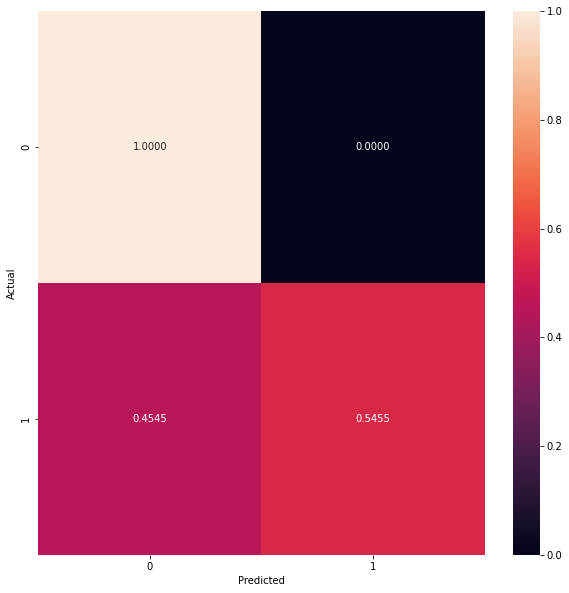

SVC(decision_function_shape='ovo', gamma=10, kernel='linear')

In [15]:
#Linear SVM for final boards classification dataset with 1/10th data
print('Linear SVM for final boards classification dataset with 1/10th data')
model(svm_final, tictac_final_data, fraction = True, svm = True)

#### Linear SVM for Tic Tac Toe Intermediate boards optimal play (single label)

Linear SVM for single boards classification dataset
Sizes of train and test datasets:((4389, 9), (4389,), (2162, 9), (2162,))
Fold: 1      Accuracy: 0.8496583143507973
Fold: 2      Accuracy: 0.8542141230068337
Fold: 3      Accuracy: 0.8633257403189066
Fold: 4      Accuracy: 0.8337129840546698
Fold: 5      Accuracy: 0.8337129840546698
Fold: 6      Accuracy: 0.8542141230068337
Fold: 7      Accuracy: 0.8815489749430524
Fold: 8      Accuracy: 0.8496583143507973
Fold: 9      Accuracy: 0.8656036446469249
Fold: 10      Accuracy: 0.8493150684931506
Train accuracy (Loss): 0.853 (0.147)
Test Accuracy (Loss): 0.847 (0.153)
Precision: 0.886
Recall: 0.803
F1_score: 0.836


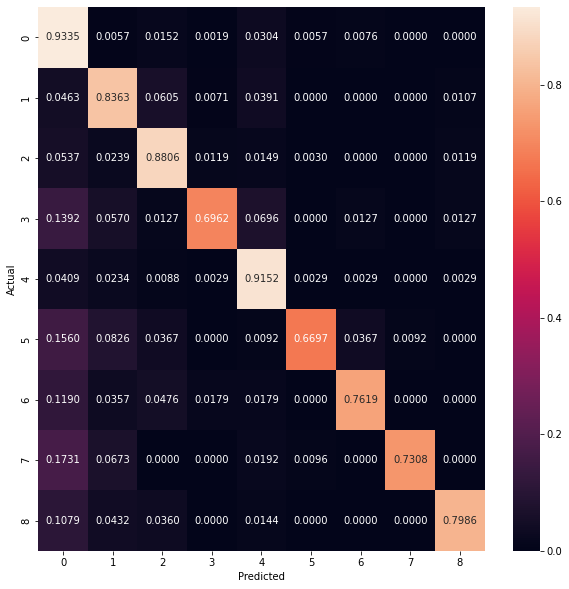

SVC(C=1.5, decision_function_shape='ovo', gamma=1.5)

In [16]:
def svmSingle(tictac_single_data, fraction):
#     X_train, X_test, y_train, y_test = preprocess(tictac_single_data, fraction, False)
#     kfold, cv = kfold_split(X_train, y_train)
#     param_grid = {"kernel": ['linear', 'rbf', 'sigmoid'], "C": [1.5, 0.5, 0.01], "decision_function_shape":['ovo', 'ovr'],
#                  "gamma": [1.5, 2]}
#     svm_gscv = GridSearchCV(SVC(), param_grid, cv=cv, n_jobs=-1)
#     svm_gscv.fit(X_train, y_train) 

#     best_hyperparams = svm_gscv.best_params_
#     optimal_kernel = best_hyperparams["kernel"]
#     optimal_c = best_hyperparams["C"]
#     optimal_gamma = best_hyperparams["gamma"]
#     optimal_decision_function_shape = best_hyperparams["decision_function_shape"]
#     print(optimal_kernel)
#     print(optimal_c)
#     print(optimal_gamma)
#     print(optimal_decision_function_shape)

# #     creating the model
#     svm_single = SVC(kernel=optimal_kernel, C = optimal_c, decision_function_shape = optimal_decision_function_shape,
#                     gamma = optimal_gamma)
    svm_single = SVC(kernel='rbf', C = 1.5, decision_function_shape = 'ovo',
                    gamma =1.5)
    return svm_single

svm_single = svmSingle(tictac_single_data, fraction = False)
print('Linear SVM for single boards classification dataset')
model(svm_single, tictac_single_data, fraction = False, svm = True)



Linear SVM for single boards classification dataset with 1/10th data
(655, 10)
Sizes of train and test datasets:((438, 9), (438,), (217, 9), (217,))
Fold: 1      Accuracy: 0.36363636363636365
Fold: 2      Accuracy: 0.22727272727272727
Fold: 3      Accuracy: 0.4090909090909091
Fold: 4      Accuracy: 0.4772727272727273
Fold: 5      Accuracy: 0.4090909090909091
Fold: 6      Accuracy: 0.3181818181818182
Fold: 7      Accuracy: 0.4318181818181818
Fold: 8      Accuracy: 0.29545454545454547
Fold: 9      Accuracy: 0.3488372093023256
Fold: 10      Accuracy: 0.4186046511627907
Train accuracy (Loss): 0.370 (0.630)
Test Accuracy (Loss): 0.392 (0.608)
Precision: 0.637
Recall: 0.240
F1_score: 0.224


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


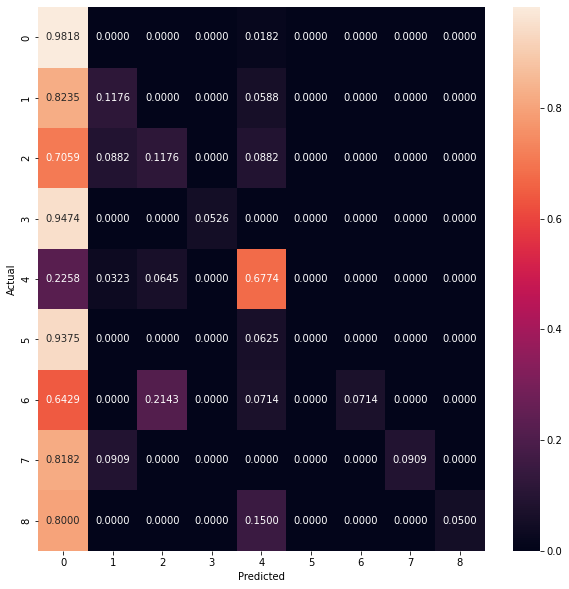

SVC(C=1.5, decision_function_shape='ovo', gamma=1.5)

In [17]:
#Linear SVM for single boards classification dataset with 1/10th data
print('Linear SVM for single boards classification dataset with 1/10th data')
model(svm_single, tictac_single_data, fraction = True, svm = True)

### Model B: k-Nearest Neighbours

#### KNN for Tic Tac Toe Final boards classification dataset

KNN for final boards classification dataset
Sizes of train and test datasets:((641, 9), (641,), (317, 9), (317,))
Fold: 1      Accuracy: 1.0
Fold: 2      Accuracy: 1.0
Fold: 3      Accuracy: 1.0
Fold: 4      Accuracy: 1.0
Fold: 5      Accuracy: 1.0
Fold: 6      Accuracy: 1.0
Fold: 7      Accuracy: 0.984375
Fold: 8      Accuracy: 1.0
Fold: 9      Accuracy: 1.0
Fold: 10      Accuracy: 1.0
Train accuracy: 0.998
Test Accuracy: 0.997
Precision: 0.997
Recall: 0.996
F1_score: 0.997


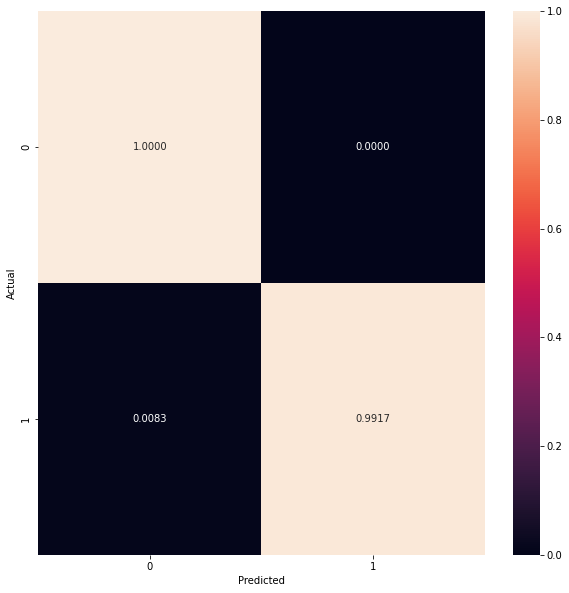

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [18]:
def knnFinal(tictac_final_data, fraction):
#     X_train, X_test, y_train, y_test = preprocess(tictac_final_data, fraction, False)
#     kfold, cv = kfold_split(X_train, y_train)
#     param_grid = {"n_neighbors": np.arange(3, 100, 1), "metric": ['euclidean','cosine','manhattan'],
#                  "weights":['uniform', 'distance']}
#     knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, n_jobs=-1)
#     knn_gscv.fit(X_train, y_train)

#     best_hyperparams = knn_gscv.best_params_
#     optimal_k = best_hyperparams["n_neighbors"]
#     optimal_metric = best_hyperparams["metric"]
#     optimal_weights = best_hyperparams["weights"]
#     print(optimal_k)
#     print(optimal_metric)
#     print(optimal_weights)

#     knn_final = KNeighborsClassifier(n_neighbors=optimal_k, metric=optimal_metric, weights = optimal_weights)
    knn_final = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights = 'uniform')
    return knn_final

knn_final = knnFinal(tictac_final_data, fraction = False)
print('KNN for final boards classification dataset')
model(knn_final, tictac_final_data, fraction = False)


KNN for final boards classification dataset with 1/10th data
(96, 10)
Sizes of train and test datasets:((64, 9), (64,), (32, 9), (32,))
Fold: 1      Accuracy: 0.7142857142857143
Fold: 2      Accuracy: 0.5714285714285714
Fold: 3      Accuracy: 0.8571428571428571
Fold: 4      Accuracy: 0.8571428571428571
Fold: 5      Accuracy: 0.8333333333333334
Fold: 6      Accuracy: 0.8333333333333334
Fold: 7      Accuracy: 0.8333333333333334
Fold: 8      Accuracy: 0.6666666666666666
Fold: 9      Accuracy: 0.6666666666666666
Fold: 10      Accuracy: 1.0
Train accuracy: 0.783
Test Accuracy: 0.781
Precision: 0.854
Recall: 0.767
F1_score: 0.762


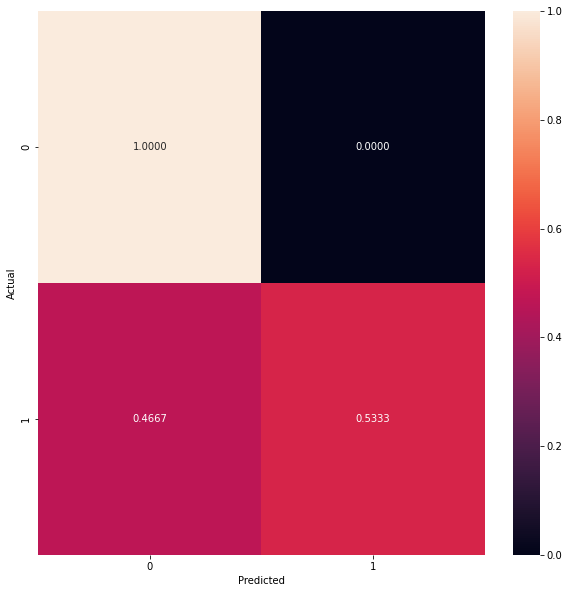

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [19]:
#KNN for final boards classification dataset with 1/10th data
print('KNN for final boards classification dataset with 1/10th data')
model(knn_final, tictac_final_data, fraction = True)

#### KNN for Tic Tac Toe Intermediate boards optimal play (single label)

KNN for single boards classification dataset
Sizes of train and test datasets:((4389, 9), (4389,), (2162, 9), (2162,))
Fold: 1      Accuracy: 0.876993166287016
Fold: 2      Accuracy: 0.8724373576309795
Fold: 3      Accuracy: 0.8792710706150342
Fold: 4      Accuracy: 0.8496583143507973
Fold: 5      Accuracy: 0.8792710706150342
Fold: 6      Accuracy: 0.856492027334852
Fold: 7      Accuracy: 0.8997722095671982
Fold: 8      Accuracy: 0.876993166287016
Fold: 9      Accuracy: 0.9020501138952164
Fold: 10      Accuracy: 0.865296803652968
Train accuracy: 0.876
Test Accuracy: 0.868
Precision: 0.866
Recall: 0.845
F1_score: 0.853


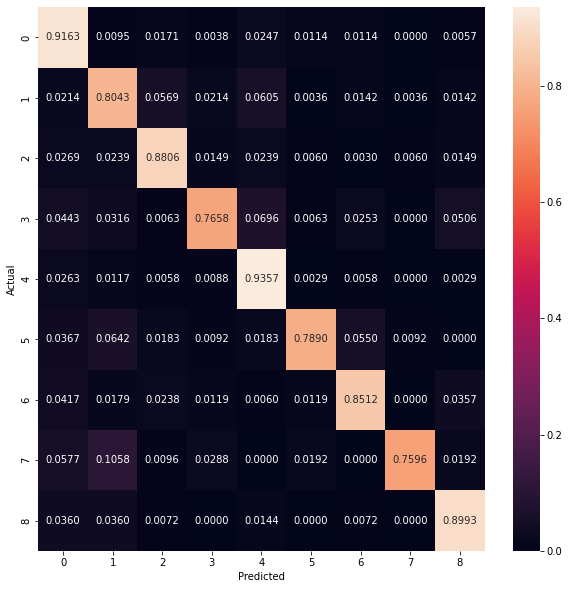

KNeighborsClassifier(metric='cosine', n_neighbors=27, weights='distance')

In [20]:
def knnSingle(tictac_single_data, fraction):
#     X_train, X_test, y_train, y_test = preprocess(tictac_single_data, fraction, False)
#     kfold, cv = kfold_split(X_train, y_train)
#     param_grid = {"n_neighbors": np.arange(3, 40, 1), "metric": ['euclidean','cosine','manhattan', 'hamming'], 
#                   "weights": ['uniform', 'distance']}
#     knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, n_jobs=-1)
#     knn_gscv.fit(X_train, y_train)

#     best_hyperparams = knn_gscv.best_params_
#     optimal_k = best_hyperparams["n_neighbors"]
#     optimal_metric = best_hyperparams["metric"]
#     optimal_weights = best_hyperparams["weights"]
#     print(optimal_k)
#     print(optimal_metric)
#     print(optimal_weights)
    
#     knn_single = KNeighborsClassifier(n_neighbors=optimal_k, metric=optimal_metric, weights=optimal_weights)
    knn_single = KNeighborsClassifier(n_neighbors=27, metric='cosine', weights='distance')
    return knn_single

knn_single = knnSingle(tictac_single_data, fraction = False)
print('KNN for single boards classification dataset')
model(knn_single, tictac_single_data, fraction = False)


KNN for single boards classification dataset with 1/10th data
(655, 10)
Sizes of train and test datasets:((438, 9), (438,), (217, 9), (217,))
Fold: 1      Accuracy: 0.5681818181818182
Fold: 2      Accuracy: 0.5681818181818182
Fold: 3      Accuracy: 0.5
Fold: 4      Accuracy: 0.5454545454545454
Fold: 5      Accuracy: 0.6136363636363636
Fold: 6      Accuracy: 0.4772727272727273
Fold: 7      Accuracy: 0.4318181818181818
Fold: 8      Accuracy: 0.6590909090909091
Fold: 9      Accuracy: 0.627906976744186
Fold: 10      Accuracy: 0.6511627906976745
Train accuracy: 0.564
Test Accuracy: 0.539
Precision: 0.663
Recall: 0.500
F1_score: 0.490


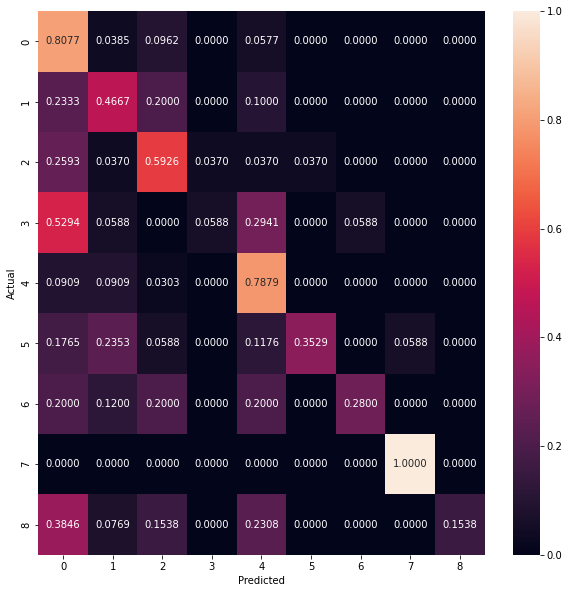

KNeighborsClassifier(metric='cosine', n_neighbors=27, weights='distance')

In [21]:
#KNN for single boards classification dataset with 1/10th data
print('KNN for single boards classification dataset with 1/10th data')
model(knn_single, tictac_single_data, fraction = True)

### Model C: Multilayer Perceptron


#### Multilayer Perceptorn for Tic Tac Toe Final boards classification dataset

MLP for final boards classification dataset
Sizes of train and test datasets:((641, 9), (641,), (317, 9), (317,))
Fold: 1      Accuracy: 0.9846153846153847
Fold: 2      Accuracy: 0.9375
Fold: 3      Accuracy: 1.0
Fold: 4      Accuracy: 1.0
Fold: 5      Accuracy: 1.0
Fold: 6      Accuracy: 1.0
Fold: 7      Accuracy: 0.984375
Fold: 8      Accuracy: 1.0
Fold: 9      Accuracy: 1.0
Fold: 10      Accuracy: 1.0
Train accuracy (Loss): 0.991 (0.001)
Test Accuracy: 0.987
Precision: 0.990
Recall: 0.983
F1_score: 0.987


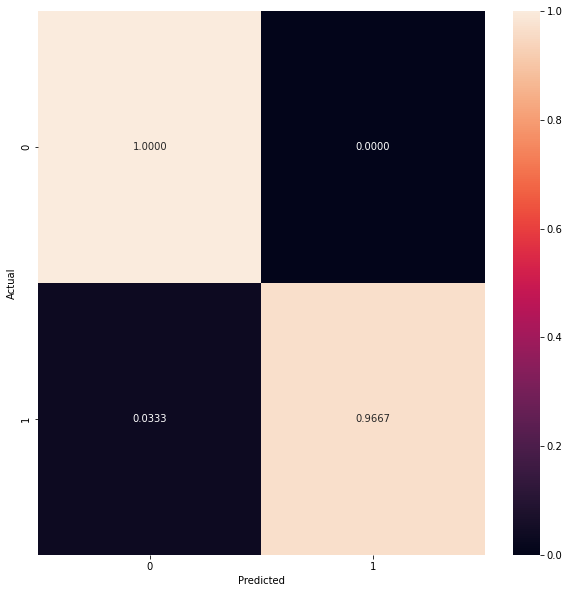

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(256, 256, 128), random_state=60)

In [22]:
def mlpFinal(tictac_final_data, fraction):
#     X_train, X_test, y_train, y_test = preprocess(tictac_final_data, fraction, False)
#     kfold, cv = kfold_split(X_train, y_train)
#     param_grid = {"hidden_layer_sizes":[(256,256,128), (200,160,128)] , "activation": ['tanh','relu'], 
#                   "solver" : ['sgd', 'adam'], "max_iter": [300, 200]}
#     knn_gscv = GridSearchCV(MLPClassifier(), param_grid, cv=cv, n_jobs=-1)
#     knn_gscv.fit(X_train, y_train)

#     best_hyperparams = knn_gscv.best_params_
#     optimal_hidden_layer_sizes = best_hyperparams["hidden_layer_sizes"]
#     optimal_activation = best_hyperparams["activation"]
#     optimal_solver = best_hyperparams["solver"]
#     optimal_max_iter = best_hyperparams["max_iter"]
#     print(optimal_hidden_layer_sizes)
#     print(optimal_activation)
#     print(optimal_solver)
#     print(optimal_max_iter)

    #creating the model
#     mlp_final = MLPClassifier(hidden_layer_sizes=optimal_hidden_layer_sizes, max_iter=optimal_max_iter, activation = optimal_activation,solver=optimal_solver, random_state=60,alpha=1e-5)
    mlp_final = MLPClassifier(hidden_layer_sizes=(256, 256, 128), max_iter=200, activation = 'relu',solver='adam', random_state=60, alpha=1e-5)
    return mlp_final

mlp_final = mlpFinal(tictac_final_data, fraction = False)
print('MLP for final boards classification dataset')
model(mlp_final, tictac_final_data, fraction = False, mlp = True)



MLP for final boards classification dataset with 1/10th data
(96, 10)
Sizes of train and test datasets:((64, 9), (64,), (32, 9), (32,))
Fold: 1      Accuracy: 0.7142857142857143
Fold: 2      Accuracy: 0.8571428571428571
Fold: 3      Accuracy: 1.0
Fold: 4      Accuracy: 0.7142857142857143
Fold: 5      Accuracy: 0.8333333333333334
Fold: 6      Accuracy: 1.0
Fold: 7      Accuracy: 1.0
Fold: 8      Accuracy: 0.6666666666666666
Fold: 9      Accuracy: 0.6666666666666666
Fold: 10      Accuracy: 0.8333333333333334
Train accuracy: 0.829
Test Accuracy: 0.625
Precision: 0.583
Recall: 0.567
F1_score: 0.564


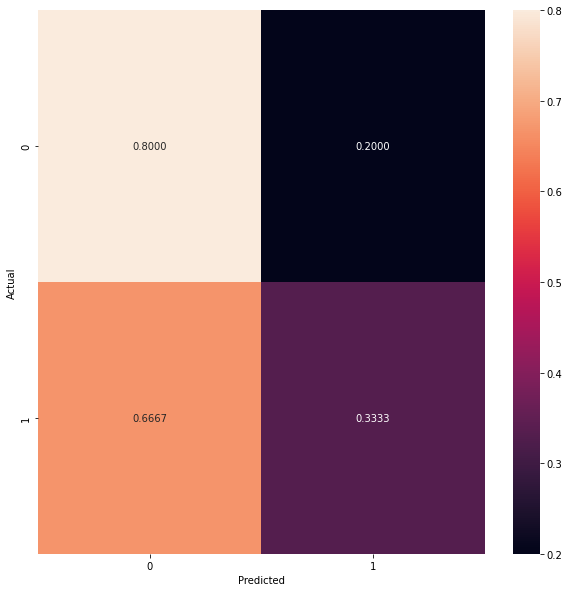

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(256, 256, 128), random_state=60)

In [23]:
#MLP for final boards classification dataset with 1/10th data
print('MLP for final boards classification dataset with 1/10th data')
model(mlp_final, tictac_final_data, fraction = True, mlp = True)

#### Multilayer Perceptron for Tic Tac Toe Intermediate boards optimal play (single label)

MLP for single boards classification dataset
Sizes of train and test datasets:((4389, 9), (4389,), (2162, 9), (2162,))
Fold: 1      Accuracy: 0.9407744874715261
Fold: 2      Accuracy: 0.9225512528473804
Fold: 3      Accuracy: 0.9066059225512528
Fold: 4      Accuracy: 0.8906605922551253
Fold: 5      Accuracy: 0.8997722095671982
Fold: 6      Accuracy: 0.8906605922551253
Fold: 7      Accuracy: 0.9202733485193622
Fold: 8      Accuracy: 0.9225512528473804
Fold: 9      Accuracy: 0.9179954441913439
Fold: 10      Accuracy: 0.8949771689497716
Train accuracy (Loss): 0.911 (0.002)
Test Accuracy: 0.909
Precision: 0.901
Recall: 0.898
F1_score: 0.899


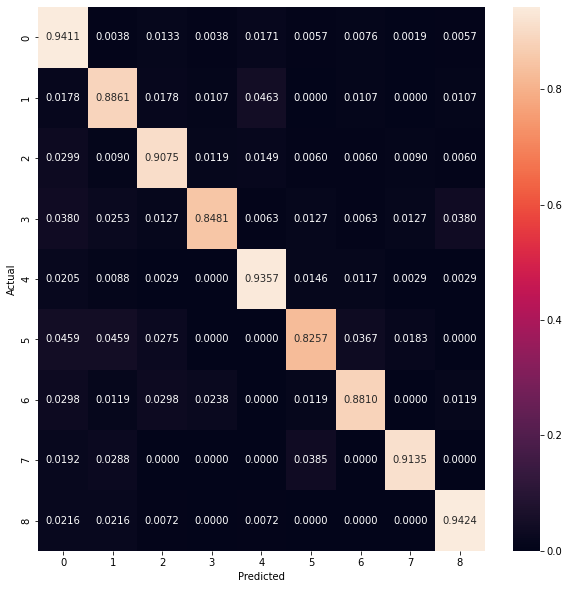

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(256, 256, 128), max_iter=300,
              random_state=50)

In [24]:
def mlpSingle(tictac_single_data, fraction):
#     X_train, X_test, y_train, y_test = preprocess(tictac_single_data, fraction, False)
#     kfold, cv = kfold_split(X_train, y_train)
#     param_grid = {"hidden_layer_sizes":[(256,256,128), (200,160,128)] , "activation": ['logistic','tanh','relu'], 
#                   "solver" : ['sgd', 'adam', 'lbfgs'], "max_iter": [300, 200]}
#     knn_gscv = GridSearchCV(MLPClassifier(), param_grid, cv=cv, n_jobs=-1)
#     knn_gscv.fit(X_train, y_train)

#     best_hyperparams = knn_gscv.best_params_
#     optimal_hidden_layer_sizes = best_hyperparams["hidden_layer_sizes"]
#     optimal_activation = best_hyperparams["activation"]
#     optimal_solver = best_hyperparams["solver"]
#     optimal_max_iter = best_hyperparams["max_iter"]
#     print(optimal_hidden_layer_sizes)
#     print(optimal_activation)
#     print(optimal_solver)
#     print(optimal_max_iter)

#     #creating the model
#     mlp_single = MLPClassifier(hidden_layer_sizes=optimal_hidden_layer_sizes, max_iter=optimal_max_iter, activation = optimal_activation ,solver= optimal_solver, random_state=50, alpha=1e-5)
    mlp_single = MLPClassifier(hidden_layer_sizes=(256, 256, 128), max_iter=300, activation = 'relu',solver='adam', random_state=50, alpha=1e-5)
    return mlp_single

mlp_single = mlpSingle(tictac_single_data, fraction = False)
print('MLP for single boards classification dataset')
model(mlp_single, tictac_single_data, fraction = False, mlp = True)



MLP for single boards classification dataset with 1/10th data
(655, 10)
Sizes of train and test datasets:((438, 9), (438,), (217, 9), (217,))
Fold: 1      Accuracy: 0.6136363636363636
Fold: 2      Accuracy: 0.7272727272727273
Fold: 3      Accuracy: 0.7045454545454546
Fold: 4      Accuracy: 0.5454545454545454
Fold: 5      Accuracy: 0.6590909090909091
Fold: 6      Accuracy: 0.6818181818181818
Fold: 7      Accuracy: 0.6363636363636364
Fold: 8      Accuracy: 0.7272727272727273
Fold: 9      Accuracy: 0.5813953488372093
Fold: 10      Accuracy: 0.7441860465116279
Train accuracy: 0.662
Test Accuracy: 0.700
Precision: 0.625
Recall: 0.644
F1_score: 0.623


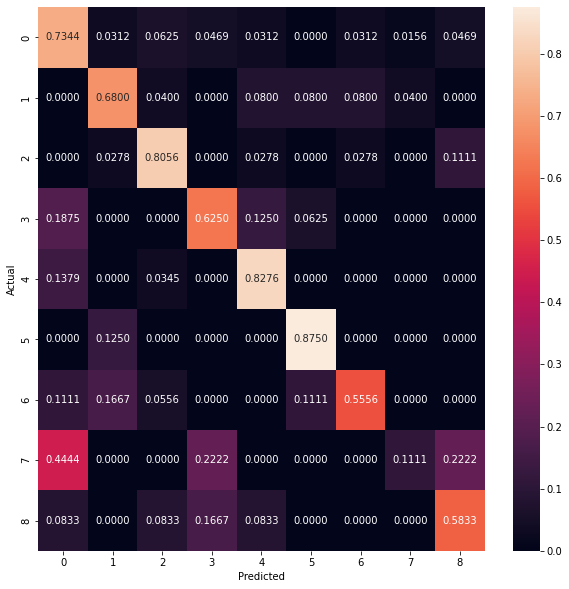

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(256, 256, 128), max_iter=300,
              random_state=50)

In [25]:
#MLP for single boards classification dataset with 1/10th data
print('MLP for single boards classification dataset with 1/10th data')
model(mlp_single, tictac_single_data, fraction = True, mlp = True)

### Model Evaluation

The table below enlists the comparative performance of the three classifiers on Tic Tac Toe Final boards classification dataset:

| Classifier | Train Accuracy | Accuracy | Precision | Recall | F-Score
|------------|----------------|----------|-----------|--------|-------
| Linear SVM | 0.984          | 0.981    | 0.985     | 0.975  | 0.980
| k-NN       | 0.998          | 0.997    | 0.997     | 0.996  | 0.997
| MLP        | 0.991          | 0.987    | 0.990     | 0.983  | 0.987

The table below enlists the comparative performance of the three classifiers on Tic Tac Toe Final boards classification dataset with 1/10th of the data:

| Classifier | Train Accuracy | Accuracy | Precision | Recall | F-Score
|------------|----------------|----------|-----------|--------|-------
| Linear SVM | 0.983          | 0.969    | 0.974     | 0.964  | 0.968
| k-NN       | 0.764          | 0.719    | 0.688     | 0.656  | 0.663
| MLP        | 0.769          | 0.750    | 0.718     | 0.655  | 0.667

The table below enlists the comparative performance of the three classifiers on Tic Tac Toe Intermediate boards optimal play (single label):

| Classifier | Train Accuracy | Accuracy | Precision | Recall | F-Score
|------------|----------------|----------|-----------|--------|-------
| Linear SVM | 0.853          | 0.847    | 0.886     | 0.803  | 0.836
| k-NN       | 0.876          | 0.868    | 0.866     | 0.845  | 0.853
| MLP        | 0.911          | 0.909    | 0.901     | 0.898  | 0.899

The table below enlists the comparative performance of the three classifiers on Tic Tac Toe Intermediate boards optimal play (single label) with 1/10th of the data:

| Classifier | Train Accuracy | Accuracy | Precision | Recall | F-Score
|------------|----------------|----------|-----------|--------|-------
| Linear SVM | 0.375          | 0.309    | 0.482     | 0.178  | 0.162
| k-NN       | 0.546          | 0.502    | 0.562     | 0.451  | 0.465
| MLP        | 0.692          | 0.682    | 0.660     | 0.665  | 0.653

## Regressor Models

In [26]:
def outputRounding(predict):
    return np.where(predict > 0.5, 1, 0)

In [27]:
def accuracyMulti(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true.iloc[i], y_pred[i])) / sum(np.logical_or(y_true.iloc[i], y_pred[i]))
    return temp / y_true.shape[0]

In [28]:
def precisionMulti(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_true.iloc[i]) == 0:
            continue
        temp += sum(np.logical_and(y_true.iloc[i], y_pred[i]))/ sum(y_true.iloc[i])
    return temp/ y_true.shape[0]

In [29]:
def recallMulti(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_pred[i]) == 0:
            continue
        temp += sum(np.logical_and(y_true.iloc[i], y_pred[i]))/ sum(y_pred[i])
    return temp/ y_true.shape[0]

In [30]:
def f1Measure(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if (sum(y_true.iloc[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp+= (2*sum(np.logical_and(y_true.iloc[i], y_pred[i])))/ (sum(y_true.iloc[i])+sum(y_pred[i]))
    return temp/ y_true.shape[0]

In [31]:
def regressorModel(model, data, fraction, mlp = False):
    X_train, X_test, y_train, y_test = preprocess(data, fraction, regression = True)
    kfold, cv = kfold_split(X_train, y_train)
    scores = []
    zeroOneLoss = []
    lossFinal = []
    loss = 0
    for k, (train, test) in enumerate(kfold):
        train_model = model.fit(X_train.iloc[train, :], y_train.iloc[train])
        predict = train_model.predict(X_train.iloc[test, :])
        predict = outputRounding(predict)
        score = accuracyMulti(y_train.iloc[test], predict)
        scores.append(score)
        if mlp:
            loss = train_model.loss_
        lossFinal.append(loss)
        print(f'Fold: {k+1}      Accuracy: {score}')  

    # report performance
    if mlp:
        print('Train accuracy (Loss): %.3f (%.3f) ' % (sum(scores) / float(len(scores)), sum(lossFinal) / float(len(lossFinal))))
    else: 
        print('Train accuracy : %.3f ' % (sum(scores) / float(len(scores))))
    y_pred = train_model.predict(X_test)
    y_pred = outputRounding(y_pred)
    print('Test accuracy: %.3f' % accuracyMulti(y_test, y_pred))
    print('Precision: %.3f ' % (precisionMulti(y_test, y_pred)))
    print('Recall: %.3f ' % (recallMulti(y_test, y_pred)))
    print('F1 score: %.3f ' % (f1Measure(y_test, y_pred)))
    return train_model, scores




### Model A: Linear Regression

#### Linear Regression for Tic Tac Toe Intermediate boards optimal play (multi label)

In [32]:
def mse(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    differences = np.subtract(actual, predicted)
    squared_differences = np.square(differences)
    return squared_differences.mean()

In [33]:
def multiple_linear_regression(X_train, y_train, X_test, y_test):
    avg_accuracy = 0
    avg_loss = 0
    
    # Creates 9 classifier models for each output vector
    for i in range(9):
        X_T = X_train.T
        
        # Product of orginal X_train and transpose of X_train
        product_X_XT = X_T.dot(X_train)
        
        # Inverse of the above product
        X_inv = np.linalg.inv(product_X_XT)
        
        # Product of X_inv and X_transpose
        product_Xinv_XT = X_inv.dot(X_T)
        
        # Theta -> Product of above resultant with y_train
        theta = product_Xinv_XT.dot(y_train.iloc[:,i:i+1])
        theta = theta.reshape(9,)
        
        # y_predictions -> product of theta with X_test
        y_pred = X_test.dot(theta)
        curr_loss = mse(y_test.iloc[:,i:i+1], y_pred)
        
        # Rounding off the predicted values
        for pred_idx in range(len(y_pred)):
            y_pred.iloc[pred_idx] = round(y_pred.iloc[pred_idx])
            
        
        curr_accuracy = accuracy_score(y_test.iloc[:,i:i+1], y_pred)
        avg_accuracy += curr_accuracy
        avg_loss += curr_loss
    
    avg_accuracy /= 9

    return avg_accuracy, avg_loss

In [34]:
X_train, X_test, y_train, y_test = preprocess(tictac_multi_data, fraction = False, regression = True)
kfold, cv = kfold_split(X_train, y_train)
scores = []
loss = []
for k, (train, test) in enumerate(kfold):
    fold_accuracy, fold_loss = multiple_linear_regression(X_train.iloc[train, :], y_train.iloc[train],X_train.iloc[test, :], y_train.iloc[test])
    scores.append(fold_accuracy)
    loss.append(fold_loss)
    print(f'Fold: {k+1}      Accuracy (Loss): {fold_accuracy} ({fold_loss})')

print('Train accuracy (Loss): %.3f (%.3f)' % (sum(scores) / float(len(scores)), sum(loss) / float(len(loss))))
test_acc, test_loss = multiple_linear_regression(X_train, y_train, X_test, y_test)
print(f'Test Accuracy (Loss): {test_acc} ({(test_loss)})')

Sizes of train and test datasets:((4389, 9), (4389, 9), (2162, 9), (2162, 9))
Fold: 1      Accuracy (Loss): 0.774487471526196 (1.7541491888956)
Fold: 2      Accuracy (Loss): 0.7833459883573779 (1.699548430703873)
Fold: 3      Accuracy (Loss): 0.7648696532523412 (1.788589880971182)
Fold: 4      Accuracy (Loss): 0.789167299417869 (1.6438463201770532)
Fold: 5      Accuracy (Loss): 0.7820804859529233 (1.6927179629094007)
Fold: 6      Accuracy (Loss): 0.7894203998987597 (1.648686598612635)
Fold: 7      Accuracy (Loss): 0.7815742849911413 (1.6972140432276028)
Fold: 8      Accuracy (Loss): 0.7790432801822323 (1.7313021828287156)
Fold: 9      Accuracy (Loss): 0.7818273854720323 (1.684677607753632)
Fold: 10      Accuracy (Loss): 0.798072044647387 (1.5874127623679055)
Train accuracy (Loss): 0.782 (1.693)
Test Accuracy (Loss): 0.7814266625552472 (1.6933109938973478)


### Model B: k-Nearest Neighbours

#### KNN for Tic Tac Toe Intermediate boards optimal play (multi label)

In [35]:
def knnMulti(tictac_multi_data, fraction):
#     X_train, X_test, y_train, y_test = preprocess(tictac_multi_data, fraction, regression = True)
#     kfold, cv = kfold_split(X_train, y_train)
#     param_grid = {"n_neighbors": np.arange(3, 100, 1), "metric": ['euclidean','cosine','manhattan', 'hamming', 'minkowski'], 
#                   "weights" : ['uniform', 'distance'], "algorithm" : ['ball_tree', 'kd_tree', 'brute']}
#     knn_gscv = GridSearchCV(KNeighborsRegressor(), param_grid, cv=cv, n_jobs=-1)
#     knn_gscv.fit(X_train, y_train)

#     best_hyperparams = knn_gscv.best_params_
#     optimal_k = best_hyperparams["n_neighbors"]
#     optimal_metric = best_hyperparams["metric"]
#     optimal_weights = best_hyperparams["weights"]
#     optimal_algorithm = best_hyperparams["algorithm"]
#     print(optimal_k)
#     print(optimal_metric)
#     print(optimal_weights)
#     print(optimal_algorithm)
#     knn_multi = KNeighborsRegressor(n_neighbors=optimal_k, metric=optimal_metric, weights = optimal_weights, algorithm = optimal_algorithm)
    #creating the model
    knn_multi = KNeighborsRegressor(n_neighbors=27, metric='manhattan', weights = 'distance')
    return knn_multi

knn_multi = knnMulti(tictac_multi_data, fraction = False)    
print('KNN for multi-label boards classification dataset')
regressorModel(knn_multi, tictac_multi_data, fraction = False)



KNN for multi-label boards classification dataset
Sizes of train and test datasets:((4389, 9), (4389, 9), (2162, 9), (2162, 9))
Fold: 1      Accuracy: 0.8456936761036983
Fold: 2      Accuracy: 0.8303395162165091
Fold: 3      Accuracy: 0.8217160212604407
Fold: 4      Accuracy: 0.8656416097190585
Fold: 5      Accuracy: 0.8435459377372815
Fold: 6      Accuracy: 0.8321564160971906
Fold: 7      Accuracy: 0.8654138192862567
Fold: 8      Accuracy: 0.8420652999240699
Fold: 9      Accuracy: 0.8292059876342336
Fold: 10      Accuracy: 0.8356164383561642
Train accuracy : 0.841 
Test accuracy: 0.840
Precision: 0.854 
Recall: 0.930 
F1 score: 0.869 


(KNeighborsRegressor(metric='manhattan', n_neighbors=27, weights='distance'),
 [0.8456936761036983,
  0.8303395162165091,
  0.8217160212604407,
  0.8656416097190585,
  0.8435459377372815,
  0.8321564160971906,
  0.8654138192862567,
  0.8420652999240699,
  0.8292059876342336,
  0.8356164383561642])

### Model C: Multilayer Perceptron

#### Multilayer Perceptron for Tic Tac Toe Intermediate boards optimal play (multi label)

In [36]:
def mlpMulti(tictac_multi_data, fraction):
#     X_train, X_test, y_train, y_test = preprocess(tictac_multi_data, fraction, regression = True)
#     kfold, cv = kfold_split(X_train, y_train)
#     param_grid = {"hidden_layer_sizes":[(300,216,200), (256,256,128)] , "activation": ['logistic','tanh','relu'], 
#                   "solver" : ['sgd', 'adam'], "max_iter": [500]}
#     knn_gscv = GridSearchCV(MLPRegressor(), param_grid, cv=cv, n_jobs=-1)
#     knn_gscv.fit(X_train, y_train)

#     best_hyperparams = knn_gscv.best_params_
#     optimal_hidden_layer_sizes = best_hyperparams["hidden_layer_sizes"]
#     optimal_activation = best_hyperparams["activation"]
#     optimal_solver = best_hyperparams["solver"]
#     print(optimal_hidden_layer_sizes)
#     print(optimal_activation)
#     print(optimal_solver)
    #creating the model
    mlp_multi = MLPRegressor(hidden_layer_sizes=(300,216,200), max_iter=500, activation = 'relu', solver='adam', random_state=20)
#     mlp_multi = MLPRegressor(hidden_layer_sizes=optimal_hidden_layer_sizes, max_iter=500, activation = optimal_activation, solver=optimal_solver, random_state=20)
    return mlp_multi


mlp_multi = mlpMulti(tictac_multi_data, fraction = False)       
print('MLP for multi-label boards classification dataset')
regressorModel(mlp_multi, tictac_multi_data, fraction = False, mlp = True)



MLP for multi-label boards classification dataset
Sizes of train and test datasets:((4389, 9), (4389, 9), (2162, 9), (2162, 9))
Fold: 1      Accuracy: 0.8951458943486278
Fold: 2      Accuracy: 0.8884640416531078
Fold: 3      Accuracy: 0.8947228549734246
Fold: 4      Accuracy: 0.8941316845644861
Fold: 5      Accuracy: 0.8947987851176917
Fold: 6      Accuracy: 0.887764399609502
Fold: 7      Accuracy: 0.8971905846621109
Fold: 8      Accuracy: 0.8814567740535849
Fold: 9      Accuracy: 0.8878999891528369
Fold: 10      Accuracy: 0.878538812785388
Train accuracy (Loss): 0.890 (0.003) 
Test accuracy: 0.887
Precision: 0.938 
Recall: 0.934 
F1 score: 0.918 


(MLPRegressor(hidden_layer_sizes=(300, 216, 200), max_iter=500, random_state=20),
 [0.8951458943486278,
  0.8884640416531078,
  0.8947228549734246,
  0.8941316845644861,
  0.8947987851176917,
  0.887764399609502,
  0.8971905846621109,
  0.8814567740535849,
  0.8878999891528369,
  0.878538812785388])

The table below enlists the comparative performance of the three classifiers on Tic Tac Toe Intermediate boards optimal play (multi label):

| Classifier | Train Accuracy | Accuracy | Precision | Recall | F-Score
|------------|----------------|----------|-----------|--------|-------
| Linear Reg | 0.782          | 0.781    |           |        |
| k-NN       | 0.841          | 0.840    | 0.854     | 0.930  | 0.869
| MLP        | 0.890          | 0.887    | 0.938     | 0.934  | 0.918